# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Класс "Вершина"



Данный класс является просто собранием данных, которые должна хранить вершина решающего дерева

In [2]:
class Node():
    def __init__(self, split_feature_index = None, split_treshhold = None, left_subtree = None,
                 right_subtree = None, node_variance_reduction = None, leaf_node_value = None):
        '''This class is simply a collection of data that the top of the decision tree should store.'''

        # Для внутренних вершин, содержащих предикат
        self.split_feature_index = split_feature_index
        self.split_treshhold = split_treshhold
        self.left_subtree = left_subtree
        self.right_subtree = right_subtree
        self.node_variance_reduction = node_variance_reduction

        # Для листовых вершин, содержащих лишь значение
        self.leaf_node_value = leaf_node_value

# Класс "Регрессия на решающих деревьях"

In [3]:
class Decision_tree_regression():
    def __init__(self, node_min_samples_quant = 2, max_depth = 2):
        '''This is the model class for decision tree regression'''

        self._node_min_samples_quant = node_min_samples_quant
        self._max_depth = max_depth

        self._root = None
    
    def fit(self, X, Y):
        '''This function we need for training the model on the training set'''

        dataset = np.concatenate((X, Y), axis = 1, dtype = object)
        self._root = self._build_tree(dataset)
    
    def _build_tree(self, dataset, current_depth = 0):
        '''This function we need for building а deсision tree'''
        X = dataset[:, :-1]
        Y = dataset[:, -1]
        
        dataset_rows_quant, dataset_features_quant = X.shape

        if dataset_rows_quant >= self._node_min_samples_quant and current_depth <= self._max_depth:
            best_split_values = self._get_best_split(dataset, dataset_features_quant)

            if best_split_values["node_variance_reduction"] > 0:
                left_subtree = self._build_tree(best_split_values["dataset_left_split"], current_depth + 1)
                right_subtree = self._build_tree(best_split_values["dataset_right_split"], current_depth + 1)

                return Node(best_split_values["split_feature_index"], best_split_values["split_treshhold"],
                            left_subtree, right_subtree, best_split_values["node_variance_reduction"])
        
        leaf_node_value = self._calculate_leaf_node_value(Y)

        return Node(leaf_node_value = leaf_node_value)

    def _get_best_split(self, dataset, dataset_features_quant):
        '''This function finds and makes the best split'''

        max_variance_reduction = -float("inf")
        best_split_values = {}

        for current_split_feature_idx in range(dataset_features_quant):
            possible_treshholds = np.unique(dataset[:, current_split_feature_idx])

            for current_split_treshhold in possible_treshholds:
                dataset_left_split, dataset_right_split = self._make_split(dataset, current_split_feature_idx,
                                                                           current_split_treshhold)

                if len(dataset_left_split) > 0 and len(dataset_right_split) > 0:
                    current_variance_reduction = self._calculate_variance_reduction(dataset, dataset_left_split,
                                                                                dataset_right_split)

                    if current_variance_reduction > max_variance_reduction:
                        best_split_values["split_feature_index"] = current_split_feature_idx
                        best_split_values["split_treshhold"] = current_split_treshhold
                        best_split_values["dataset_left_split"] = dataset_left_split
                        best_split_values["dataset_right_split"] = dataset_right_split
                        best_split_values["node_variance_reduction"] = current_variance_reduction
                        max_variance_reduction = current_variance_reduction
        
        return best_split_values

    def _make_split(self, dataset, dataset_split_feature_index, dataset_split_treshhold):
        '''This function produces the best sample split'''
        dataset_left_split = np.array([row for row in dataset if row[dataset_split_feature_index] <= dataset_split_treshhold])
        dataset_right_split = np.array([row for row in dataset if row[dataset_split_feature_index] > dataset_split_treshhold])

        return dataset_left_split, dataset_right_split
    
    def _calculate_variance_reduction(self, dataset, dataset_left_split, dataset_right_split):
        '''This function calculates the reduction between the variance of the parent
        node and the sum of the variances of the child nodes'''

        dataset_targets = dataset[:, -1]
        dataset_left_split_targets = dataset_left_split[:, -1]
        dataset_right_split_targets = dataset_right_split[:, -1]

        card_dataset_left_split = len(dataset_left_split)
        card_dataset_right_split = len(dataset_right_split)
        card_dataset = len(dataset_targets)

        dataset_left_split_targets_variance = np.var(dataset_left_split_targets)
        dataset_right_split_targets_variance = np.var(dataset_right_split_targets)
        dataset_targets_variance = np.var(dataset_targets)

        dataset_variance = card_dataset * dataset_targets_variance
        split_variance = card_dataset_left_split * dataset_left_split_targets_variance + \
                         card_dataset_right_split * dataset_right_split_targets_variance

        variance_reduction = dataset_variance - split_variance

        return variance_reduction

    def _calculate_leaf_node_value(self, dataset_targets):
        '''This function calculates the value that will be contained in the node if it is a leaf'''

        return np.mean(dataset_targets)

    def predict(self, data):
        '''This function predicts the values ​​(class labels) for the sample that was passed as an argument'''

        predictions = np.array([self._make_prediction(data_sample, self._root) for data_sample in data])

        return predictions

    def _make_prediction(self, sample, current_node):
        '''This function predicts a value (class label) for a particular sample object'''

        if current_node.leaf_node_value != None:
            return current_node.leaf_node_value
        else:
            feature_value = sample[current_node.split_feature_index]

            if feature_value <= current_node.split_treshhold:
                return self._make_prediction(sample, current_node.left_subtree)
            else:
                return self._make_prediction(sample, current_node.right_subtree)

# Инициализируем входные данные

## Для начала импортируем датасет

In [4]:
df = pd.read_csv("/content/sample_data/dataset_for_linear_regression.csv")
df

,x,x**2,x**3,x**4,x**5,x**6,x**7,y
0,-2.000000,4.000000,-8.000000,16.000000,-32.000000,64.000000,-128.000000,-0.270671
1,-1.988848,3.955515,-7.866916,15.646097,-31.117701,61.888365,-123.086526,-0.272180
2,-1.977695,3.911278,-7.735316,15.298097,-30.254972,59.835113,-118.335613,-0.273689
3,-1.966543,3.867290,-7.605192,14.955935,-29.411485,57.838944,-113.742755,-0.275198
4,-1.955390,3.823551,-7.476535,14.619545,-28.586917,55.898581,-109.303545,-0.276706
...,...,...,...,...,...,...,...,...
265,0.955390,0.912771,0.872052,0.833150,0.795984,0.760475,0.726551,2.483714
266,0.966543,0.934205,0.902949,0.872739,0.843539,0.815317,0.788039,2.540886
267,0.977695,0.955888,0.934567,0.913722,0.893341,0.873415,0.853934,2.599029
268,0.988848,0.977820,0.966914,0.956131,0.945468,0.934924,0.924497,2.658156


## Теперь разделим его на список объектов и список соответствующих им таргетов

In [5]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)

## Сделаем разделение списка объектов и таргетов на тренировочные и тестовые

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1/3, random_state = 42)

X_test_len = len(X_test)
Y_test_len = len(Y_test)

# Создаем модель регрессии на рещающих деревьях и тренируем ее на нашем датасете

In [7]:
model = Decision_tree_regression(node_min_samples_quant=4, max_depth=4)
model.fit(X_train, Y_train)

# Используя тестовую выборку, сделаем нужные предсказания

In [8]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred.reshape(-1, 1)
Y_pred_len = len(Y_pred)

# Теперь выведем график, на котором будут отражены объекты тестовой выборки их истиные таргеты и предсказания модели

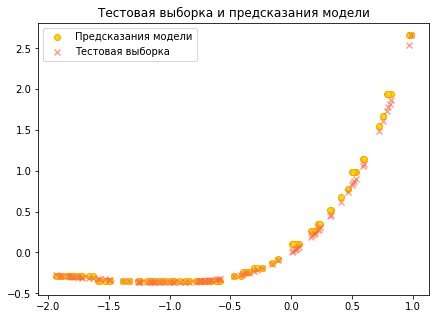

In [9]:
graph_X_values = X_test[:, 0]
graph_Y_test_values = Y_test
grapg_Y_pred_values = Y_pred

figure, ax = plt.subplots()

figure.set_figwidth(7)
figure.set_figheight(5)

ax.set_title('Тестовая выборка и предсказания модели')

ax.scatter(graph_X_values, grapg_Y_pred_values, color = "gold",
           edgecolors='orange', label = "Предсказания модели")
ax.scatter(graph_X_values, graph_Y_test_values, color = "tomato",
           label = "Тестовая выборка", marker = "x", alpha = 0.6)

ax.legend()

plt.show()

# В дополнение к графику можно вывести две таблицы

## Таблица с истиными значениями таргетов для соответствующих объектов

In [10]:
test_df = pd.DataFrame(np.concatenate((X_test, Y_test.reshape(-1, 1)), axis = 1),
             columns = ["x", "x**2", "x**3", "x**4", "x**5", "x**6", "x**7", "y"])
test_df.head()

,x,x**2,x**3,x**4,x**5,x**6,x**7,y
0,-1.665428,2.773649,-4.619311,7.693128,-12.812346,21.338034,-35.536949,-0.314949
1,-0.706320,0.498888,-0.352374,0.248889,-0.175795,0.124167,-0.087702,-0.348538
2,-1.118959,1.252069,-1.401015,1.567678,-1.754168,1.962842,-2.196340,-0.365474
3,-0.583643,0.340639,-0.198812,0.116035,-0.067723,0.039526,-0.023069,-0.325592
4,0.185874,0.034549,0.006422,0.001194,0.000222,0.000041,0.000008,0.223842


## Таблица с предсказанными значениями таргетов для соответствующих объектов

In [11]:
pred_df = pd.DataFrame(np.concatenate((X_test, Y_pred), axis = 1),
             columns = ["x", "x**2", "x**3", "x**4", "x**5", "x**6", "x**7", "y"])
pred_df.head()

,x,x**2,x**3,x**4,x**5,x**6,x**7,y
0,-1.665428,2.773649,-4.619311,7.693128,-12.812346,21.338034,-35.536949,-0.294454
1,-0.706320,0.498888,-0.352374,0.248889,-0.175795,0.124167,-0.087702,-0.347513
2,-1.118959,1.252069,-1.401015,1.567678,-1.754168,1.962842,-2.196340,-0.347513
3,-0.583643,0.340639,-0.198812,0.116035,-0.067723,0.039526,-0.023069,-0.347513
4,0.185874,0.034549,0.006422,0.001194,0.000222,0.000041,0.000008,0.256358


Я вывел лишь начало таблиц, так как вывод полностью всей таблицы занял бы много места. Удивительно, что дерево справилось настолько хорошо, я прямо в восторге!